In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from pandas import ExcelWriter
from pandas import ExcelFile
import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style

2019 Annual data for plant nameplate is not available until at least June 2020, therefore 2018 is most recent annual data available for capacity factor evaluations.  Generator information (Plant nameplate capacities) is taken from EIA Form 860 (Generator information) (available at https://www.eia.gov/electricity/data/eia860/) and production data is from EIA form 923 (available at https://www.eia.gov/electricity/data/eia923/).

In [2]:
nameplate_2018 = pd.read_excel("3_1_Generator_Y2018.xlsx", skiprows=1)
production_2018 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx",skiprows=5)
#production_2018.head()
#nameplate_2018.head()

In [3]:
production_2018.shape

(13962, 97)

In [4]:
nameplate_2018.shape

(22119, 73)

In [5]:
name_columns = ['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name', 'Operating Year',\
            'State','County','Technology','Prime Mover','Energy Source 1','Nameplate Capacity (MW)']

In [6]:
prod_columns =['Plant Id','Plant Name', 'Operator Name','Plant State','Reported\nPrime Mover',\
       'Reported\nFuel Type Code', 'AER\nFuel Type Code','Netgen\nJanuary', 'Netgen\nFebruary', 'Netgen\nMarch', \
        'Netgen\nApril','Netgen\nMay', 'Netgen\nJune', 'Netgen\nJuly', 'Netgen\nAugust','Netgen\nSeptember', \
        'Netgen\nOctober', 'Netgen\nNovember','Netgen\nDecember','Net Generation\n(Megawatthours)','YEAR']

In [7]:
nameplate_2018_sum = nameplate_2018[name_columns].copy()
prod_2018_sum = production_2018[prod_columns].copy()

In [8]:
monthly = ['Netgen\nJanuary', 'Netgen\nFebruary', 'Netgen\nMarch', 'Netgen\nApril','Netgen\nMay', 'Netgen\nJune', \
           'Netgen\nJuly', 'Netgen\nAugust','Netgen\nSeptember','Netgen\nOctober', 'Netgen\nNovember','Netgen\nDecember']

In [9]:
for i in monthly:
    prod_2018_sum[i] = pd.to_numeric(prod_2018_sum[i], errors = 'coerce')

Overall 2018 Electricity Production in US (MW-hrs)

In [10]:
prod_total_18 = prod_2018_sum['Net Generation\n(Megawatthours)'].sum()
"2018: {:.2E} MW-hr".format(Decimal(str(prod_total_18)))

'2018: 4.17E+9 MW-hr'

In [11]:
prod_2018_sum['Reported\nFuel Type Code'].value_counts()

NG     3291
SUN    2780
DFO    2355
WAT    1480
WND    1117
BIT     414
LFG     389
SUB     252
WDS     241
RFO     221
OBG     143
MWH     123
OG      119
NUC      99
BLQ      94
KER      80
GEO      72
MSB      69
MSN      69
JF       63
RC       59
PC       54
TDF      50
WO       47
PG       41
WH       37
WC       29
LIG      26
OBS      25
OTH      24
SLW      23
AB       22
OBL      18
PUR      13
BFG      12
SGC       4
WDL       3
SC        3
SGP       1
Name: Reported\nFuel Type Code, dtype: int64

There were 99 Nuclear (NUC) units and 2780 Solar (SUN) plant units operating in 2018. Note that a given plant may be comprised of multiple units, this analysis will be based on aggregating individual unit data to plant level information.  This is more appropriate to understand the number of standalone power stations and performance at a given plant location.  What was overall 2018 production for nuclear and solar?

In [12]:
sun = prod_2018_sum[prod_2018_sum['Reported\nFuel Type Code'] == 'SUN']['Net Generation\n(Megawatthours)'].sum()
"2018 Solar: {:.2E} MW-hr".format(Decimal(str(sun)))

'2018 Solar: 6.38E+7 MW-hr'

In [13]:
nuc = prod_2018_sum[prod_2018_sum['Reported\nFuel Type Code'] == 'NUC']['Net Generation\n(Megawatthours)'].sum()
"2018 Nuclear: {:.2E} MW-hr".format(Decimal(str(nuc)))

'2018 Nuclear: 8.07E+8 MW-hr'

What about capacity factor?  Capacity factor is the ratio of power produced compared to the operating (nameplate) capacity
of a plant. Let's take a look at the aggregrate values (values based on total aggregate production as compared to total reported aggregate nameplate capacity).

In [14]:
nuc_nameplate = nameplate_2018_sum[nameplate_2018_sum['Energy Source 1'] == 'NUC']['Nameplate Capacity (MW)'].sum()
"2018 Nuclear: {:.2E} MW".format(Decimal(str(nuc_nameplate)))

'2018 Nuclear: 1.04E+5 MW'

In [15]:
solar_nameplate = nameplate_2018_sum[nameplate_2018_sum['Energy Source 1'] == 'SUN']['Nameplate Capacity (MW)'].sum()
"2018 Solar: {:.2E} MW".format(Decimal(str(solar_nameplate)))

'2018 Solar: 3.22E+4 MW'

In [16]:
"2018 Solar Capacity Factor: {}".format(sun/(solar_nameplate*24*365))

'2018 Solar Capacity Factor: 0.22600153838901937'

In [17]:
"2018 Nuclear Capacity Factor: {}".format(nuc/(nuc_nameplate*24*365))

'2018 Nuclear Capacity Factor: 0.8835979135398567'

Let's take a closer look, down to the state and plant level to understand more about what this mean.

In [18]:
prod_2018_sum['Net Generation\n(Megawatthours)'].sum()

4174397655.6009965

In [19]:
nuc_prod = prod_2018_sum[prod_2018_sum['Reported\nFuel Type Code'] == 'NUC'].copy()
nuc_nameplate = nameplate_2018_sum[nameplate_2018_sum['Energy Source 1'] == 'NUC'].copy()

Indian Point individual units are named as unique plants, this is a correction so that the two Indian Point units can be properly grouped as a single unit (station), "Indian Point".

In [20]:
name_fix = dict.fromkeys(['Indian Point 2', 'Indian Point 3'], "Indian Point")

In [21]:
nuc_prod['Plant Name'].replace(to_replace = name_fix, inplace = True)
nuc_nameplate['Plant Name'].replace(to_replace = name_fix, inplace = True)

In [22]:
sun_prod = prod_2018_sum[prod_2018_sum['Reported\nFuel Type Code'] == 'SUN'].copy()
sun_nameplate = nameplate_2018_sum[nameplate_2018_sum['Energy Source 1'] == 'SUN'].copy()

In [23]:
nuc_name_merge = nuc_nameplate.groupby('Plant Name').agg({'Utility ID':'first', 'Utility Name':'first', \
    'Plant Code':'first','Operating Year':'first', 'State':'first', 'County':'first', 'Technology':'first',\
    'Energy Source 1':'first','Nameplate Capacity (MW)':np.sum})

nuc_prod_merge = nuc_prod.groupby('Plant Name').agg({'Plant Id':'first', 'Reported\nFuel Type Code':'first', \
      'Netgen\nJanuary':np.sum, 'Netgen\nFebruary':np.sum, 'Netgen\nMarch':np.sum, 'Netgen\nApril':np.sum,\
      'Netgen\nMay':np.sum, 'Netgen\nJune':np.sum,'Netgen\nJuly':np.sum, 'Netgen\nAugust':np.sum,'Netgen\nSeptember':np.sum,\
        'Netgen\nOctober':np.sum, 'Netgen\nNovember':np.sum,'Netgen\nDecember':np.sum, 'Net Generation\n(Megawatthours)':np.sum,\
        'YEAR':'first'})

Merge data from 923 (production) and 860 (Generator data) to create a table which has production and nameplate capacity for each plant in the same table.  This will allow calculation of capacity factors at the individual plant level.

In [24]:
nuc_name_merge = nuc_name_merge.reset_index(level = 'Plant Name')
nuc_prod_merge = nuc_prod_merge.reset_index(level = 'Plant Name')

In [25]:
nuc_prod_merge.shape, nuc_name_merge.shape

((60, 17), (59, 10))

In [26]:
nuc_2018 = pd.merge(nuc_prod_merge, nuc_name_merge, left_on = ['Plant Name'],right_on = ['Plant Name'], how ='left')
nuc_2018.shape

(60, 26)

In [27]:
nuc_check = nuc_2018['Net Generation\n(Megawatthours)'].sum()
nuc, nuc_check

(807084477.0, 807084477.0)

Oyster Creek was permanently inactivated on 9/17/2018 and the nameplate capacity was not reported on 2018 form EIA-860. Plant nameplate capacity of 550 MW from 2017 EIA-860 is appended to this data to allow determination of capacity factor for 2018 operation prior to shutdown. 

In [28]:
nuc_2018['Nameplate Capacity (MW)'].isnull().sum()

1

In [29]:
nuc_2018['Nameplate Capacity (MW)'].fillna(value=550, inplace=True)

In [30]:
nuc_2018['Nameplate Capacity (MW)'].isnull().sum()

0

In [31]:
monthly = ['Netgen\nDecember', 'Netgen\nFebruary', 'Netgen\nMarch', 'Netgen\nSeptember', 'Netgen\nNovember', 'Netgen\nJuly', \
           'Netgen\nOctober','Netgen\nJanuary', 'Netgen\nAugust', 'Netgen\nApril', 'Netgen\nMay','Netgen\nJune']

In [32]:
nuc_2018['Active Months'] = 12 - nuc_2018[monthly].isnull().astype(int).values.sum(axis=1) 

Effectively all of the nuclear plants were operating for all 12 months.  This is expected, as there were no new construction plants and only one plant (Oyster Creek) which shutdown during the year (did not operate in months following shutdown).

In [33]:
nuc_2018['Active Months'].value_counts()

12    59
10     1
Name: Active Months, dtype: int64

In [34]:
nuc_2018['Capacity_norm'] = 24*365*nuc_2018['Nameplate Capacity (MW)']*(nuc_2018['Active Months']/12)

In [35]:
nuc_2018['Capacity_factor'] = nuc_2018['Net Generation\n(Megawatthours)']/nuc_2018['Capacity_norm']

This is almost identical to the aggregate value of .8835 calcuated at the beginning.  The small difference is because the nameplate capacity for Oyster Creek was not included in the original aggregate values, which results in a slightly higher aggregate capacity factor.  

In [36]:
nuc_2018['Net Generation\n(Megawatthours)'].sum()/nuc_2018['Capacity_norm'].sum()

0.8797309408615502

Let's look at statistics for capacity factor for each individual plant, to understand how much variation there is across the fleet.  Notice that the mean capacity factor for the fleet is slightly lower than the aggregate.  This is because the aggregate is a weighted average for all generation, where when taking the mean of individual plant values, all plants are weighted equally, even though there is a large variation in output for the smallest to largest stations.  However, again, there is minimal difference in the calculated average value for individual plants and the fleet as a whole.  This indicates very consistent performance.

In [37]:
nuc_2018['Capacity_factor'].describe()

count    60.000000
mean      0.873374
std       0.075370
min       0.548537
25%       0.830159
50%       0.885622
75%       0.923968
max       0.984266
Name: Capacity_factor, dtype: float64

In [38]:
sun_name_merge = sun_nameplate.groupby('Plant Name').agg({'Utility ID':'first', 'Utility Name':'first', \
    'Plant Code':'first','Operating Year':'first', 'State':'first', 'County':'first', 'Technology':'first',\
    'Energy Source 1':'first','Nameplate Capacity (MW)':np.sum})

sun_prod_merge = sun_prod.groupby('Plant Name').agg({'Plant Id':'first', 'Reported\nFuel Type Code':'first', \
      'Netgen\nJanuary':np.sum, 'Netgen\nFebruary':np.sum, 'Netgen\nMarch':np.sum, 'Netgen\nApril':np.sum,\
      'Netgen\nMay':np.sum, 'Netgen\nJune':np.sum,'Netgen\nJuly':np.sum, 'Netgen\nAugust':np.sum,'Netgen\nSeptember':np.sum,\
        'Netgen\nOctober':np.sum, 'Netgen\nNovember':np.sum,'Netgen\nDecember':np.sum, 'Net Generation\n(Megawatthours)':np.sum,\
        'YEAR':'first'})

Merge solar data as performed for nuclear above, to allow determination of capacity factor at the plant level.

In [39]:
sun_name_merge = sun_name_merge.reset_index(level = 'Plant Name')
sun_prod_merge = sun_prod_merge.reset_index(level = 'Plant Name')

In [40]:
sun_name_merge.shape, sun_prod_merge.shape

((2769, 10), (2759, 17))

In [41]:
sun_2018 = pd.merge(sun_prod_merge, sun_name_merge, left_on = ['Plant Name'],right_on = ['Plant Name'], how ='left')
sun_2018.shape

(2759, 26)

In [42]:
sun_check = sun_2018['Net Generation\n(Megawatthours)'].sum()
sun, sun_check

(63825323.16999999, 63825323.16999998)

In [43]:
sun_2018['Active Months'] = 12 - sun_2018[monthly].isnull().astype(int).values.sum(axis=1) 

In [44]:
sun_2018['Active Months'].value_counts() 

12    2384
1      113
10      35
3       31
6       31
4       28
2       28
7       25
5       24
8       24
11      19
9       17
Name: Active Months, dtype: int64

In [45]:
sun_2018[sun_2018['Active Months'] != 12]['Active Months'].value_counts().sum() 

375

Although approximately 85% of the solar plants operated for all 12 months, there were a significant number of plants which did not have 12 months of production.  However, looking at 'Operating Year' (year in which plant was put into service), there were 385 new plants which came on-line in 2018.  This is consistent with a total of 375 plants which had output for less than 12 months. Based on plants coming on-line at various times in 2018, it is expected that only a handful of new plants would have generation for all 12 months in 2018.  Because there was a non-trivial number of new plants which only operated for part of the year, it is important to weight the capacity versus months in service instead of assuming every plant operated for the full year.

In [46]:
sun_2018['Operating Year'].value_counts()

2017.0    468
2016.0    446
2018.0    385
2015.0    349
2014.0    298
2013.0    232
2012.0    211
2011.0    159
2010.0     59
2009.0     30
2008.0     19
2007.0     12
2006.0      3
2005.0      3
1988.0      2
2001.0      2
1986.0      2
2002.0      1
1987.0      1
1989.0      1
1990.0      1
Name: Operating Year, dtype: int64

A significant amount of new solar capacity was added in 2018, but less than in 2016 and 2017.

In [47]:
sun_2018.groupby('Operating Year')['Nameplate Capacity (MW)'].sum().sort_values(ascending=False)

Operating Year
2016.0    7834.2
2017.0    5133.8
2018.0    4201.9
2013.0    3972.8
2015.0    3466.6
2014.0    3321.9
2012.0    1614.8
2011.0     884.1
2010.0     238.9
2007.0     106.6
2009.0      98.4
1990.0      92.0
1989.0      92.0
1988.0      70.0
1986.0      68.4
2008.0      38.5
1987.0      34.2
2001.0      13.6
2006.0       7.6
2005.0       2.3
2002.0       2.1
Name: Nameplate Capacity (MW), dtype: float64

In [48]:
sun_2018['Nameplate Capacity (MW)'].isnull().sum()

75

There are 75 plants with reported production in 2018 for which nameplate capacity was not reported.  Including 75 plants with reported production, but no reported nameplate capacity will distort capacity factor evaluations. Let's removed these plants from the evaluation. 

In [49]:
sun_2018.shape

(2759, 27)

In [50]:
sun_2018 = sun_2018[sun_2018['Nameplate Capacity (MW)']>0]
sun_2018.shape

(2684, 27)

In [51]:
sun_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 0 to 2758
Data columns (total 27 columns):
Plant Name                        2684 non-null object
YEAR                              2684 non-null int64
Netgen
November                   2575 non-null float64
Netgen
January                    2329 non-null float64
Reported
Fuel Type Code           2684 non-null object
Plant Id                          2684 non-null int64
Netgen
April                      2397 non-null float64
Netgen
December                   2682 non-null float64
Netgen
March                      2380 non-null float64
Netgen
September                  2518 non-null float64
Net Generation
(Megawatthours)    2684 non-null float64
Netgen
October                    2549 non-null float64
Netgen
August                     2493 non-null float64
Netgen
February                   2348 non-null float64
Netgen
July                       2470 non-null float64
Netgen
June                       2441 non-null float64
Net

We now have a table which has non-null values for nameplate capacity and net generation for each plant.

In [52]:
sun_2018['Capacity_norm'] = 24*365*sun_2018['Nameplate Capacity (MW)']*(sun_2018['Active Months']/12)

In [53]:
sun_2018['Capacity_factor'] = sun_2018['Net Generation\n(Megawatthours)']/sun_2018['Capacity_norm']

In [54]:
sun_2018['Net Generation\n(Megawatthours)'].sum()/sun_2018['Capacity_norm'].sum()

0.2449890732933267

The mean values calculated for solar capacity factor at the plant level are considerably lower than the aggregate capacity factors of 0.226 and 0.254. However, the plant level averages are not weighted (the smallest and largest capacity plants count equally), so the plant level values do not fairly represent the industry as a whole. 

In [55]:
sun_2018['Capacity_factor'].describe()

count    2684.000000
mean        0.189537
std         0.096331
min         0.000000
25%         0.151624
50%         0.188537
75%         0.223405
max         3.017979
Name: Capacity_factor, dtype: float64

One challenge to trying to understand variations in capacity factor among plants is the much larger variation in the size of solar plants, as compared to nuclear.  The largest and smallest size solar plants vary by three orders of magnitude, whereas the size of all nuclear plants is within one order (factor of 8).  Likewise, the size of the typical solar plant is heavily left skewed, with the majority of plants being small (less than ~3 MW)

In [56]:
sun_2018['Nameplate Capacity (MW)'].min(), sun_2018['Nameplate Capacity (MW)'].median(), sun_2018['Nameplate Capacity (MW)'].max()

(0.10000000000000001, 3.3, 585.90000000000009)

In [57]:
nuc_2018['Nameplate Capacity (MW)'].min(), nuc_2018['Nameplate Capacity (MW)'].median(), nuc_2018['Nameplate Capacity (MW)'].max()

(550.0, 1802.5500000000002, 4209.6000000000004)

Aggregating data by state, and then taking a weighted average at the state level may provide results that are slightly more realistic.  It removes the extreme outliers (including values greater than one) and does slightly increase the mean capacity factor (so it is closer to the industry aggregate), but the mean value is still almost 20% less than the overall industry mean.

In [58]:
sun_state_cap = sun_2018.groupby('State')['Net Generation\n(Megawatthours)'].sum()/sun_2018.groupby('State')['Capacity_norm'].sum()
sun_state_cap.describe()

count    46.000000
mean      0.197034
std       0.056558
min       0.012269
25%       0.160775
50%       0.194256
75%       0.232059
max       0.296113
dtype: float64

One challenge is that the state of CA alone contributes almost half of the overall industry capacity.  And the next most significant state contributes more than 75% less capacity.  However, it may still be appropriate to consider capacity factors at the state level, because that is where the power is produced.  California may be an advantageous location to produce solar power, but it may be much less efficient in other states.  

In [59]:
(sun_2018.groupby('State')['Net Generation\n(Megawatthours)'].sum()/sun_2018['Net Generation\n(Megawatthours)'].sum()).sort_values(ascending=False)

State
CA    0.433349
NC    0.097129
AZ    0.076526
NV    0.071877
TX    0.042300
FL    0.037552
UT    0.035743
GA    0.032040
NM    0.021631
CO    0.016949
MN    0.016619
MA    0.015023
NJ    0.014966
VA    0.012265
OR    0.009138
ID    0.008936
SC    0.008075
MD    0.006309
AL    0.005521
MS    0.005238
NY    0.004741
IN    0.004670
AR    0.003270
TN    0.002694
HI    0.002302
OH    0.001914
MI    0.001864
CT    0.001553
VT    0.001512
MO    0.001466
PA    0.001004
OK    0.000991
IL    0.000860
DE    0.000787
KY    0.000634
WI    0.000575
MT    0.000484
RI    0.000464
NE    0.000436
ME    0.000193
IA    0.000184
KS    0.000124
WA    0.000027
SD    0.000027
LA    0.000024
WY    0.000013
Name: Net Generation\n(Megawatthours), dtype: float64

As seen below, AZ, NV and CA have state level capacity factors of 0.29, 0.28 and 0.27 respectively and as shown above, these three states account for almost 60% of the total solar production.  So this explains why the industry wide mean capacity factor is 0.245, even though the average of all the individual plants is slightly less than 0.200.  However the takeaway is that outside of the Southwester united states, solar capacity factors are much lower elsewhere.  Meaning solar energy is a much less economically solution in these other regions.  Likewise, because electricty generation is regional, using national level capacity factors to evaluate the economics of projects in a particular region is potentially highly misleading.

In [60]:
sun_state_cap.sort_values(ascending = False)

State
UT    0.296113
AZ    0.287692
NM    0.280273
NV    0.280076
CA    0.272967
ID    0.264443
CO    0.257384
TX    0.245395
ME    0.245263
OR    0.241180
OK    0.237133
AR    0.232207
MS    0.231618
MT    0.229041
FL    0.226189
AL    0.223526
GA    0.223239
HI    0.221044
KS    0.220519
CT    0.216768
SC    0.205042
VA    0.198689
NC    0.197644
SD    0.190868
WI    0.189059
MO    0.186472
MN    0.183254
TN    0.180829
DE    0.177686
NE    0.176688
IL    0.173910
OH    0.171890
KY    0.171172
IN    0.167140
NY    0.158653
MA    0.157974
LA    0.157534
RI    0.157477
MI    0.152416
NJ    0.151934
VT    0.148653
MD    0.143156
IA    0.142148
PA    0.126620
WA    0.052295
WY    0.012269
dtype: float64

Let's revisit the nuclear plant capacity factors to get the most direct comparison the solar plants. 

In [61]:
nuc_state_cap = nuc_2018.groupby('State')['Net Generation\n(Megawatthours)'].sum()/nuc_2018.groupby('State')['Capacity_norm'].sum()
nuc_state_cap.describe()

count    30.000000
mean      0.867947
std       0.080048
min       0.548537
25%       0.832669
50%       0.890575
75%       0.911925
max       0.984266
dtype: float64

The average value is pretty similar to the values calculated at the plant level.  A number of states only have a single nuclear plant, so this is not surprising.  As can be seen below, the total industry capacity is much less concentrated (at a state level than solar).  The three states with the larges production, acount for less than 30% as compared to almost 60% in the solar industry.

In [62]:
(nuc_2018.groupby('State')['Net Generation\n(Megawatthours)'].sum()/nuc_2018['Net Generation\n(Megawatthours)'].sum()).sort_values(ascending=False)

State
IL    0.121551
PA    0.103430
SC    0.065317
NY    0.053178
NC    0.052135
TX    0.051030
AL    0.048896
TN    0.044824
GA    0.042576
AZ    0.038530
MI    0.037764
FL    0.036319
VA    0.036244
NJ    0.035240
OH    0.022693
CA    0.022567
LA    0.021253
CT    0.020917
MD    0.018570
MN    0.018091
AR    0.015761
MO    0.013202
WI    0.012550
NH    0.012467
WA    0.012029
KS    0.011360
MS    0.008573
NE    0.006978
IA    0.006066
MA    0.005503
Name: Net Generation\n(Megawatthours), dtype: float64

In [63]:
sun_2018.groupby('State')['Net Generation\n(Megawatthours)'].sum().sort_values(ascending=False)

State
CA    26960351.00
NC     6042775.15
AZ     4761007.03
NV     4471766.18
TX     2631650.00
FL     2336270.98
UT     2223706.00
GA     1993346.00
NM     1345731.48
CO     1054461.23
MN     1033936.84
MA      934632.39
NJ      931070.27
VA      763072.00
OR      568538.00
ID      555964.00
SC      502388.48
MD      392495.00
AL      343498.00
MS      325853.00
NY      294939.00
IN      290522.48
AR      203413.00
TN      167594.00
HI      143209.12
OH      119055.06
MI      115981.00
CT       96606.00
VT       94095.00
MO       91230.55
PA       62475.30
OK       61626.00
IL       53473.00
DE       48978.71
KY       39436.00
WI       35772.91
MT       30096.00
RI       28866.00
NE       27112.00
ME       12031.63
IA       11456.00
KS        7727.00
WA        1695.00
SD        1672.00
LA        1518.00
WY         824.00
Name: Net Generation\n(Megawatthours), dtype: float64

In [64]:
nuc_state_cap.sort_values(ascending = False)

State
MO    0.984266
GA    0.970528
MD    0.935611
OH    0.934708
NH    0.924795
WA    0.923558
TX    0.914951
VA    0.913756
PA    0.906431
IL    0.902031
WI    0.899139
CA    0.895036
NJ    0.894257
CT    0.890985
MN    0.890775
NC    0.890375
FL    0.881217
LA    0.875814
SC    0.875313
NY    0.858134
AL    0.854753
AZ    0.843290
TN    0.829129
KS    0.825596
IA    0.822422
MI    0.806496
NE    0.802670
AR    0.787072
MA    0.756758
MS    0.548537
dtype: float64

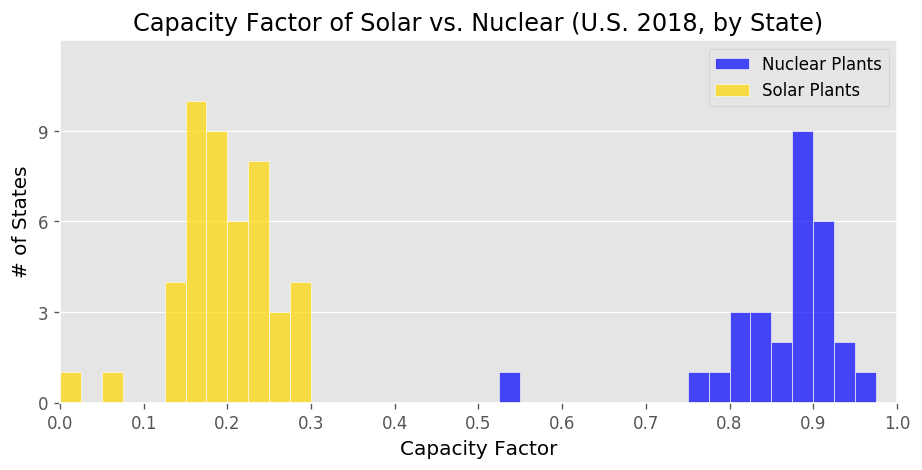

In [79]:
plt.style.use('ggplot')
plt.figure(figsize=(9, 4), dpi=120)
#bins = [x for x in range(0, 10,1)]
bins = np.arange(0,1,.025)
#plt.xlim(35,85)
plt.xlim(0,1)
plt.ylim(0,12)
plt.xticks(np.arange(0,1.1,.1))
plt.yticks(np.arange(0,12,3))
#plt.hist(nuc_2018['Capacity_factor'], bins=12, color = 'green', alpha = 0.7, label = 'Nuclear Plants', ec='white')
plt.hist(nuc_state_cap, bins=bins, color = 'blue', alpha = 0.7, label = 'Nuclear Plants', ec='white')
plt.hist(sun_state_cap, bins=bins, color = 'gold', alpha = 0.7, label = 'Solar Plants', ec='white')
plt.tick_params(right='off',top='off')
plt.grid(b=False, axis='x')
plt.title('Capacity Factor of Solar vs. Nuclear (U.S. 2018, by State)')
plt.xlabel('Capacity Factor',color='black')
plt.ylabel('# of States', color='black')
plt.legend(loc='best',prop={'size': 10})
plt.show()

In [66]:
production_2019 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2019_21FEB2020.xlsx",skiprows=5)
#production_2018 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx",skiprows=5)
production_2017 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2017_Final_Revision.xlsx",skiprows=5)

In [67]:
production_2016 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2016_Final_Revision.xlsx",skiprows=5)
production_2015 = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2015_Final_Revision.xlsx",skiprows=5)

In [68]:
prod_columns =['Plant Id','Plant Name', 'Operator Name','Plant State','Reported\nPrime Mover',\
       'Reported\nFuel Type Code', 'AER\nFuel Type Code','Net Generation\n(Megawatthours)','YEAR']

In [69]:
prod_2019_sum = production_2019[prod_columns].copy()
prod_2018_sum = production_2018[prod_columns].copy()
prod_2017_sum = production_2017[prod_columns].copy()
prod_2016_sum = production_2016[prod_columns].copy()
prod_2015_sum = production_2015[prod_columns].copy()

In [70]:
fuel_dict = {'NUC': 'Nuclear', 'WAT':'Hydro','GEO':'Geothermal','WND':'Wind','SUN':'Solar'}
fuel_dict.update(dict.fromkeys(['SUB','BIT','RC','WC','LIG', 'ANT','SC','SGC'],'Coal'))
fuel_dict.update(dict.fromkeys(['NG','PG'],'Natural Gas')) 
fuel_dict.update(dict.fromkeys(['WDS','BLQ','WDL'],'Wood'))
fuel_dict.update(dict.fromkeys(['OBG','OBS','OBL','AB','MSB'],'Biomass'))
fuel_dict.update(dict.fromkeys(['RFO','DFO','JF','SGP','KER','PC'],'Petroleum'))
fuel_dict.update(dict.fromkeys(['MSN','LFG','TDF', 'WO','SLW'],'Waste'))
fuel_dict.update(dict.fromkeys(['WH', 'OTH','PUR','OG', 'BFG'],'Other'))

In [71]:
prod_2019_sum['Primary Fuel'] = prod_2019_sum['Reported\nFuel Type Code'].map(fuel_dict)
prod_2018_sum['Primary Fuel'] = prod_2018_sum['Reported\nFuel Type Code'].map(fuel_dict)
prod_2017_sum['Primary Fuel'] = prod_2017_sum['Reported\nFuel Type Code'].map(fuel_dict)
prod_2016_sum['Primary Fuel'] = prod_2016_sum['Reported\nFuel Type Code'].map(fuel_dict)
prod_2015_sum['Primary Fuel'] = prod_2015_sum['Reported\nFuel Type Code'].map(fuel_dict)

In [72]:
fossil_dict = {'Nuclear': 'Nuclear','Solar':'Solar'}
fossil_dict.update(dict.fromkeys(['Coal','Natural Gas','Petroleum'],'Fossil'))

In [73]:
prod_2019_sum['Fossil?'] = prod_2019_sum['Primary Fuel'].map(fossil_dict)
prod_2018_sum['Fossil?'] = prod_2018_sum['Primary Fuel'].map(fossil_dict)
prod_2017_sum['Fossil?'] = prod_2017_sum['Primary Fuel'].map(fossil_dict)
prod_2016_sum['Fossil?'] = prod_2016_sum['Primary Fuel'].map(fossil_dict)
prod_2015_sum['Fossil?'] = prod_2015_sum['Primary Fuel'].map(fossil_dict)

In [74]:
prod_2019_sum.head()

,Plant Id,Plant Name,Operator Name,Plant State,Reported Prime Mover,Reported Fuel Type Code,AER Fuel Type Code,Net Generation (Megawatthours),YEAR,Primary Fuel,Fossil?
0,3,Barry,Alabama Power Co,AL,CA,NG,NG,2824887.00,2019,Natural Gas,Fossil
1,3,Barry,Alabama Power Co,AL,CT,NG,NG,5306391.00,2019,Natural Gas,Fossil
2,3,Barry,Alabama Power Co,AL,ST,BIT,COL,4174904.20,2019,Coal,Fossil
3,3,Barry,Alabama Power Co,AL,ST,NG,NG,164624.81,2019,Natural Gas,Fossil
4,3,Barry,Alabama Power Co,AL,ST,SUB,COL,0.00,2019,Coal,Fossil


In [75]:
Prod_type_2019 = prod_2019_sum.groupby(['Fossil?'])['Net Generation\n(Megawatthours)'].sum()
Prod_type_2019 = Prod_type_2019.sort_values(ascending=False)
Prod_type_2018 = prod_2018_sum.groupby(['Fossil?'])['Net Generation\n(Megawatthours)'].sum()
Prod_type_2018 = Prod_type_2018.sort_values(ascending=False)
Prod_type_2017 = prod_2017_sum.groupby(['Fossil?'])['Net Generation\n(Megawatthours)'].sum()
Prod_type_2017 = Prod_type_2017.sort_values(ascending=False)
Prod_type_2016 = prod_2016_sum.groupby(['Fossil?'])['Net Generation\n(Megawatthours)'].sum()
Prod_type_2016 = Prod_type_2016.sort_values(ascending=False)
Prod_type_2015 = prod_2015_sum.groupby(['Fossil?'])['Net Generation\n(Megawatthours)'].sum()
Prod_type_2015 = Prod_type_2015.sort_values(ascending=False)
Prod_type_2015

Fossil?
Fossil     2.713266e+09
Nuclear    7.971779e+08
Solar      2.489290e+07
Name: Net Generation\n(Megawatthours), dtype: float64

In [76]:
solar = []
nuclear = []
fossil = []

data = [Prod_type_2015, Prod_type_2016, Prod_type_2017, Prod_type_2018, Prod_type_2019]
for i in data:
    fossil.append(i[0])
    nuclear.append(i[1])
    solar.append(i[2])
    
fossil, nuclear, solar      

([2713265825.148005,
  2640887626.5520058,
  2522877640.4460068,
  2639065599.3250012,
  2565497070.3839998],
 [797177877.0, 805693948.0, 804949635.0, 807084477.0, 809409262.0],
 [24892903.602000006,
  36054121.147000015,
  53286174.327000022,
  63825323.169999987,
  72234173.688000023])

In [77]:
#scaling for graphic
fossil_p = []
nuclear_p = []
solar_p = []

for i in fossil:
    fossil_p.append(i/1000000000)

for i in nuclear:
    nuclear_p.append(i/1000000000)

for i in solar:
    solar_p.append(i/1000000000)

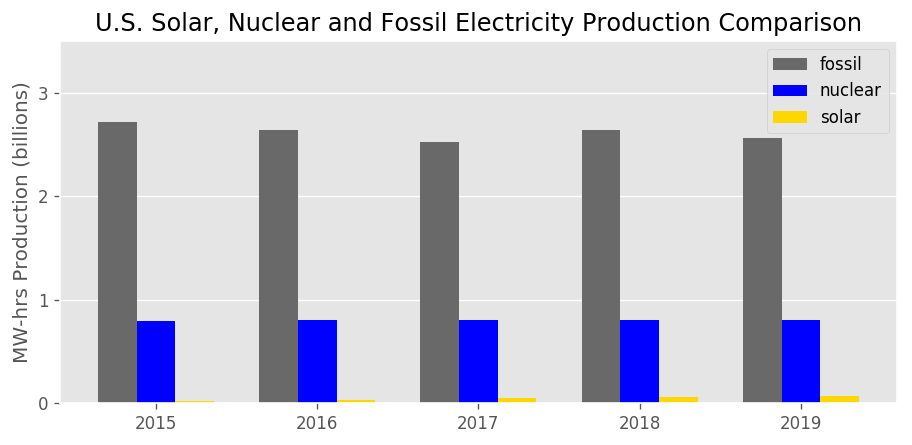

In [78]:
dates = [2015, 2016, 2017, 2018, 2019]
x = np.arange(len(dates))

width = 0.24

fig, ax = plt.subplots(figsize=(9, 4.0), dpi=120)
fos = ax.bar(x - width, fossil_p, width, color = 'dimgray', label='fossil')
nuc = ax.bar(x, nuclear_p, width, color = 'blue', label='nuclear')
sol = ax.bar(x + width, solar_p, width, color = 'gold', label='solar')

plt.title('U.S. Solar, Nuclear and Fossil Electricity Production Comparison')
ax.set_ylabel('MW-hrs Production (billions)')
plt.ylim(0,3.5)
plt.yticks(np.arange(0,3.5,1))
ax.set_xticks(x)
ax.set_xticklabels(dates)
plt.grid(b=False, axis='x')

plt.legend()
plt.show()